In [117]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

In [2]:
path = os.listdir('SDSS_20k/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('SDSS_20k/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

872
15249
32951
37233
37879
45552
63104
63918
72767
81185
88285
96972
101023
122609


In [4]:
np.min(Image_RGB)

-0.1562042649972083

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (140976, 64, 64, 5)
train_label.shape: (140976, 3)


In [6]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [7]:
autoencoder.fit(train_data[:100000], train_data[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(train_data[100000:140000],train_data[100000:140000]),callbacks=[EarlyStopping])

Train on 100000 samples, validate on 40000 samples
Epoch 1/100
100000/100000 [==============================] - 146s - loss: 0.1682 - val_loss: 0.1088
Epoch 2/100
100000/100000 [==============================] - 137s - loss: 0.1041 - val_loss: 0.1009
Epoch 3/100
100000/100000 [==============================] - 132s - loss: 0.0927 - val_loss: 0.0927
Epoch 4/100
100000/100000 [==============================] - 130s - loss: 0.0858 - val_loss: 0.0814
Epoch 5/100
100000/100000 [==============================] - 130s - loss: 0.0815 - val_loss: 0.0909
Epoch 6/100
100000/100000 [==============================] - 129s - loss: 0.0791 - val_loss: 0.0724
Epoch 7/100
100000/100000 [==============================] - 129s - loss: 0.0771 - val_loss: 0.0889
Epoch 8/100
100000/100000 [==============================] - 130s - loss: 0.0754 - val_loss: 0.0804
Epoch 9/100
100000/100000 [==============================] - 130s - loss: 0.0737 - val_loss: 0.0703
Epoch 10/100
100000/100000 [=====================

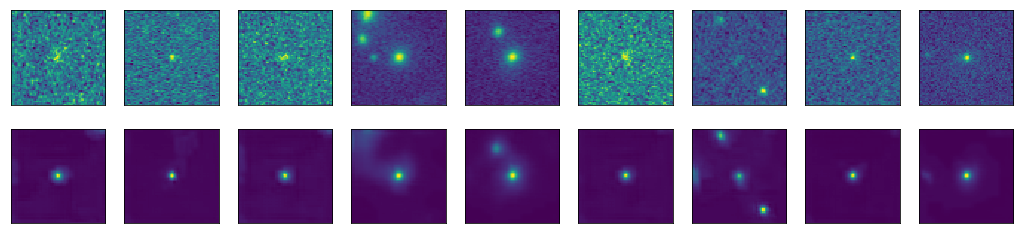

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = autoencoder.predict(train_data[0:100],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:100][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [9]:
encoder = Model(inputs=input_img, outputs=encoded)
encoded_variables = encoder.predict(train_data[:120000],batch_size=100)
encoded_variables.shape

(120000, 30)

In [10]:
net_2_input= Input(shape=(30,))
FC_1 = Dense(units=15, activation='relu')(net_2_input)
net_2_output = Dense(units=3, activation='sigmoid')(FC_1)

classifier = Model(net_2_input,net_2_output)
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

In [35]:
classifier.fit(encoded_variables, label[:120000], batch_size=100, nb_epoch=40,shuffle=True,verbose=1,validation_split=0.2)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 96000 samples, validate on 24000 samples
Epoch 1/40
96000/96000 [==============================] - 4s - loss: 0.4888 - acc: 0.8429 - val_loss: 0.3009 - val_acc: 0.8810
Epoch 2/40
96000/96000 [==============================] - 4s - loss: 0.2766 - acc: 0.8910 - val_loss: 0.2722 - val_acc: 0.8898
Epoch 3/40
96000/96000 [==============================] - 4s - loss: 0.2597 - acc: 0.9006 - val_loss: 0.2623 - val_acc: 0.9015
Epoch 4/40
96000/96000 [==============================] - 4s - loss: 0.2517 - acc: 0.9082 - val_loss: 0.2564 - val_acc: 0.9086
Epoch 5/40
96000/96000 [==============================] - 5s - loss: 0.2461 - acc: 0.9116 - val_loss: 0.2522 - val_acc: 0.9082
Epoch 6/40
96000/96000 [==============================] - 5s - loss: 0.2418 - acc: 0.9133 - val_loss: 0.2484 - val_acc: 0.9106
Epoch 7/40
96000/96000 [==============================] - 5s - loss: 0.2384 - acc: 0.9144 - val_loss: 0.2482 - val_acc: 0.9119
Epoch 8/40
96000/96000 [==============================] - 4s 

In [11]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

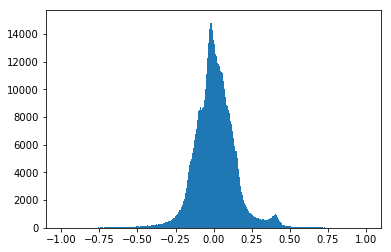

In [12]:
plt.hist(Zero_one_normalized_encoded_variables.reshape(-1,),2000)
plt.show()

In [13]:
Zero_one_normalized_encoded_variables.shape

(120000, 30)

# AE 

In [14]:
net_3_input= Input(shape=(30,))
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
encoded = Dense(2, activation='tanh')(net_3_input)
decoded = Dense(30, activation='tanh')(encoded)

autoencoder = Model(input=net_3_input, output=decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [15]:
autoencoder.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 4s - loss: 0.0102 - val_loss: 0.0086
Epoch 2/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 3/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 4/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 5/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 6/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 7/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 8/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 9/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0085
Epoch 10/100
96000/96000 [==============================] - 3s - loss: 0.0089 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


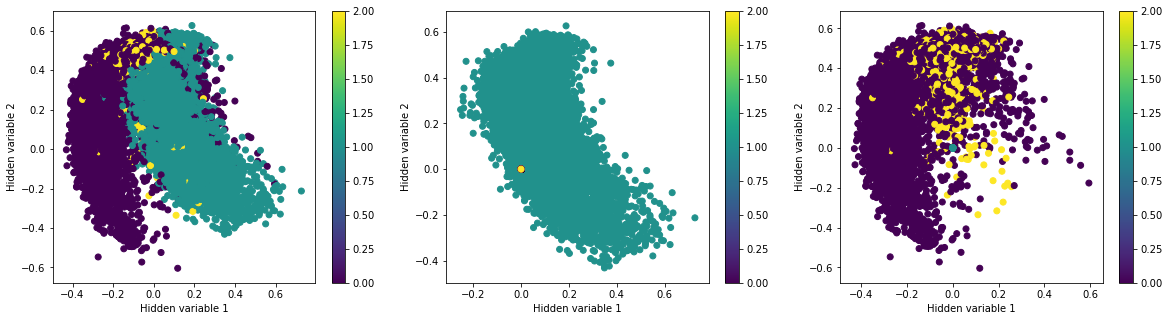

In [100]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]!=1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [105]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,0]<0:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1
(star_corr + gala_corr)/upper_lim

0.8301666666666667

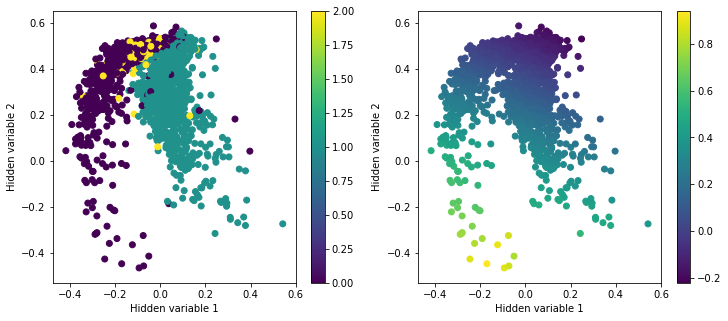

In [71]:
lower_lim = 0
upper_lim = 3000


x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [84]:
n_neighbors = 10
n_components = 1
X = np.asarray(hid_pred,dtype='float64')
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y_pred = se.fit_transform(X)

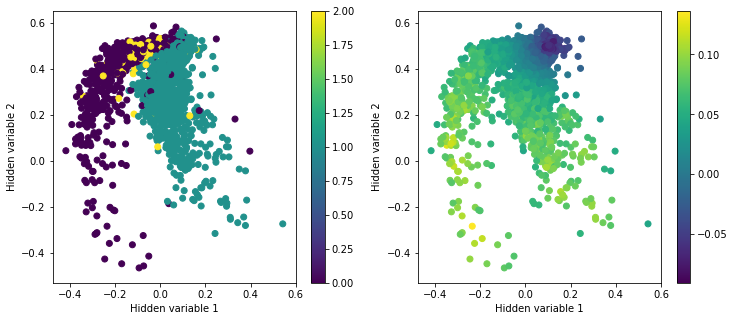

In [85]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [91]:
methods = ['standard', 'ltsa', 'hessian', 'modified']
Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=methods[3]).fit_transform(X)

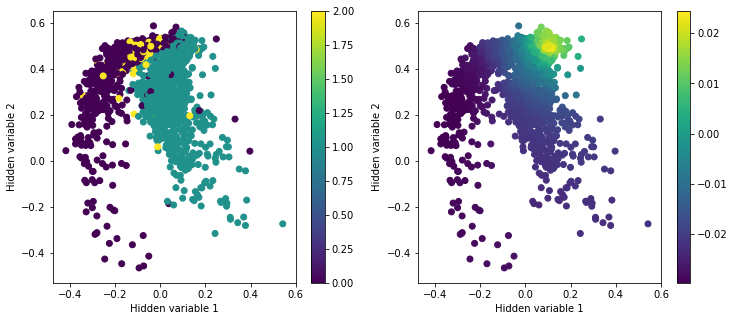

In [92]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [68]:
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)

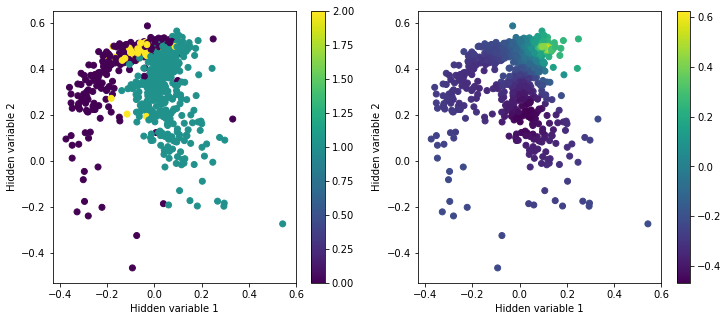

In [69]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

# VAE KLterm = 0.1

In [126]:
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)
z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.1*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [127]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 7s - loss: 0.6715 - val_loss: 0.3736
Epoch 2/100
96000/96000 [==============================] - 6s - loss: 0.3941 - val_loss: 0.3450
Epoch 3/100
96000/96000 [==============================] - 6s - loss: 0.3861 - val_loss: 0.3431
Epoch 4/100
96000/96000 [==============================] - 6s - loss: 0.3851 - val_loss: 0.3452
Epoch 5/100
96000/96000 [==============================] - 6s - loss: 0.3845 - val_loss: 0.3425
Epoch 6/100
96000/96000 [==============================] - 6s - loss: 0.3834 - val_loss: 0.3396
Epoch 7/100
96000/96000 [==============================] - 6s - loss: 0.3819 - val_loss: 0.3401
Epoch 8/100
96000/96000 [==============================] - 6s - loss: 0.3808 - val_loss: 0.3381
Epoch 9/100
96000/96000 [==============================] - 6s - loss: 0.3799 - val_loss: 0.3376
Epoch 10/100
96000/96000 [==============================] - 6s - loss: 0.3786 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


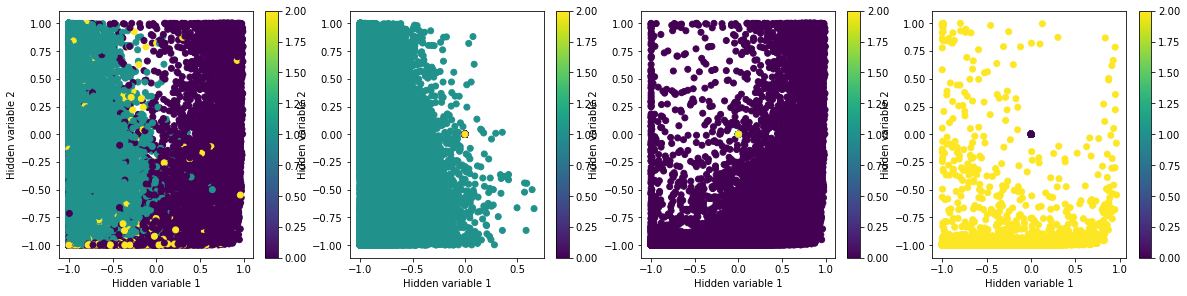

In [128]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]!=1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]!=0]=0

x_vis_3 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_3[label_value[lower_lim:upper_lim]!=2]=0

plt.figure(figsize=(20, 10))

ax = plt.subplot(2,4,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(2,4,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(2,4,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(2,4,4)
plt.scatter( x_vis_3[:, 0] ,x_vis_3[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [133]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,0]>-0.:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [134]:
(star_corr + gala_corr)/upper_lim

0.7940666666666667

# VAE KLterm = 0.3

In [135]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.3*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [136]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 7s - loss: -0.5952 - val_loss: -0.9332
Epoch 2/100
96000/96000 [==============================] - 6s - loss: -0.8969 - val_loss: -0.9411
Epoch 3/100
96000/96000 [==============================] - 6s - loss: -0.9006 - val_loss: -0.9445
Epoch 4/100
96000/96000 [==============================] - 6s - loss: -0.9028 - val_loss: -0.9477
Epoch 5/100
96000/96000 [==============================] - 6s - loss: -0.9047 - val_loss: -0.9479
Epoch 6/100
96000/96000 [==============================] - 6s - loss: -0.9072 - val_loss: -0.9503
Epoch 7/100
96000/96000 [==============================] - 6s - loss: -0.9087 - val_loss: -0.9519
Epoch 8/100
96000/96000 [==============================] - 6s - loss: -0.9097 - val_loss: -0.9533
Epoch 9/100
96000/96000 [==============================] - 6s - loss: -0.9087 - val_loss: -0.9532
Epoch 10/100
96000/96000 [==============================] - 6s - los

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


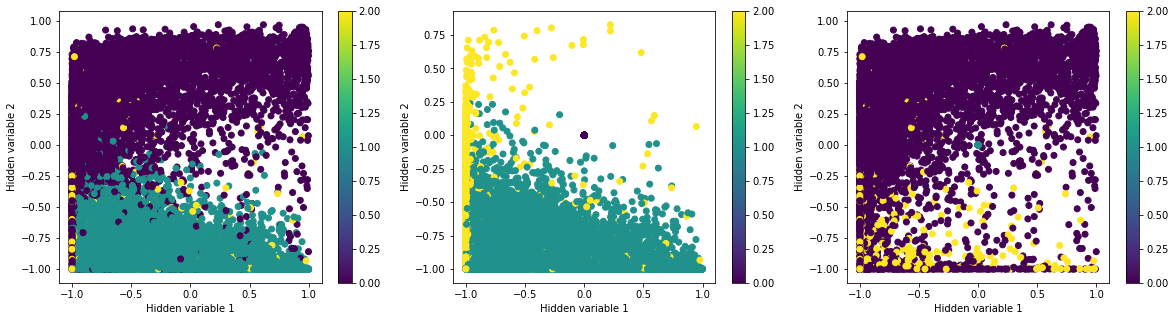

In [137]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [162]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,1]>-0.39:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [163]:
(star_corr + gala_corr)/upper_lim

0.7835416666666667

# VAE KLterm=0.05

In [200]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.05*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [201]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 7s - loss: 0.9419 - val_loss: 0.7390
Epoch 2/100
96000/96000 [==============================] - 6s - loss: 0.7631 - val_loss: 0.7149
Epoch 3/100
96000/96000 [==============================] - 6s - loss: 0.7581 - val_loss: 0.7160
Epoch 4/100
96000/96000 [==============================] - 6s - loss: 0.7576 - val_loss: 0.7153
Epoch 5/100
96000/96000 [==============================] - 6s - loss: 0.7576 - val_loss: 0.7153
Epoch 6/100
96000/96000 [==============================] - 6s - loss: 0.7573 - val_loss: 0.7141
Epoch 7/100
96000/96000 [==============================] - 6s - loss: 0.7565 - val_loss: 0.7130
Epoch 8/100
96000/96000 [==============================] - 6s - loss: 0.7555 - val_loss: 0.7135
Epoch 9/100
96000/96000 [==============================] - 6s - loss: 0.7552 - val_loss: 0.7122
Epoch 10/100
96000/96000 [==============================] - 6s - loss: 0.7547 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


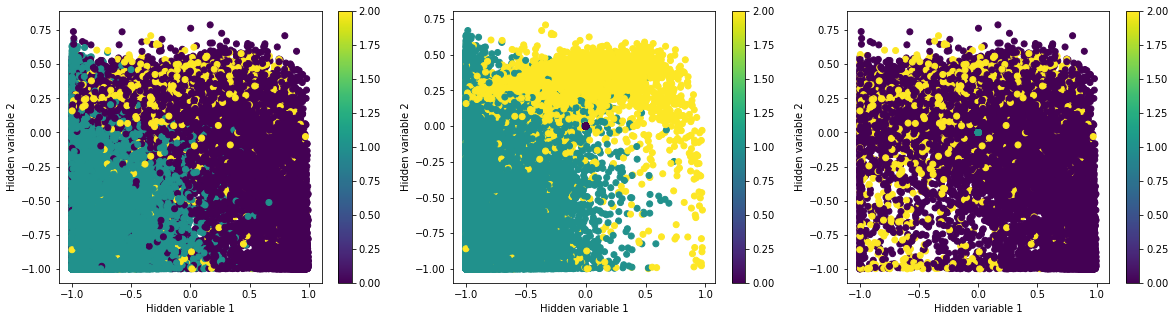

In [202]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [208]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,0]>0 or x_vis[i,1]>0.25:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [209]:
(star_corr + gala_corr)/upper_lim

0.8822416666666667

# m=0.5 VAE KLterm=0.05

In [215]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(0.7)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.005*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [216]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 7s - loss: 1.0771 - val_loss: 0.8762
Epoch 2/100
96000/96000 [==============================] - 6s - loss: 0.9143 - val_loss: 0.8735
Epoch 3/100
96000/96000 [==============================] - 6s - loss: 0.9120 - val_loss: 0.8726
Epoch 4/100
96000/96000 [==============================] - 6s - loss: 0.9109 - val_loss: 0.8709
Epoch 5/100
96000/96000 [==============================] - 6s - loss: 0.9099 - val_loss: 0.8699
Epoch 6/100
96000/96000 [==============================] - 6s - loss: 0.9093 - val_loss: 0.8693
Epoch 7/100
96000/96000 [==============================] - 6s - loss: 0.9088 - val_loss: 0.8691
Epoch 8/100
96000/96000 [==============================] - 6s - loss: 0.9085 - val_loss: 0.8690
Epoch 9/100
96000/96000 [==============================] - 6s - loss: 0.9081 - val_loss: 0.8691
Epoch 10/100
96000/96000 [==============================] - 6s - loss: 0.9079 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


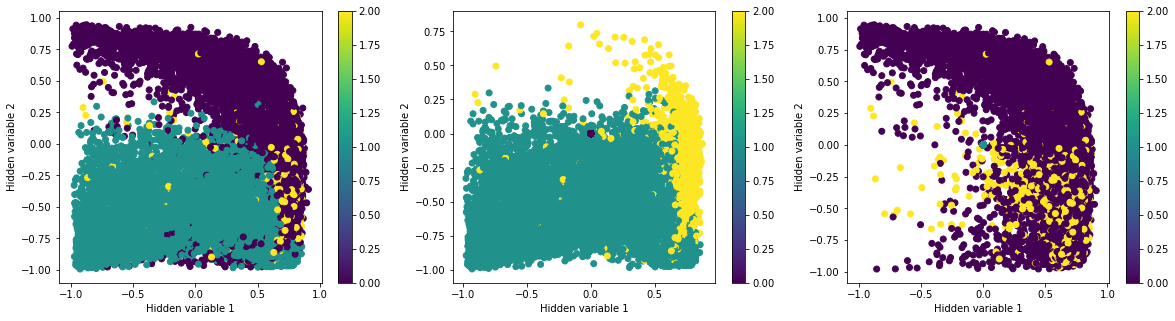

In [217]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [236]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,1]>0.1 or x_vis[i,0]>0.68:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [237]:
(star_corr + gala_corr)/upper_lim

0.9080333333333334

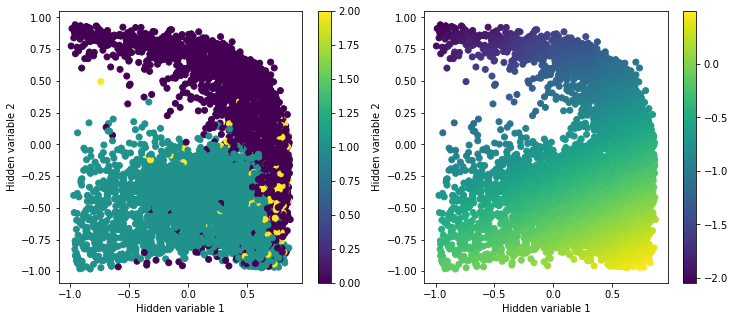

In [241]:
lower_lim = 0
upper_lim = 30000


x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

3000
AUC: 0.721767195864


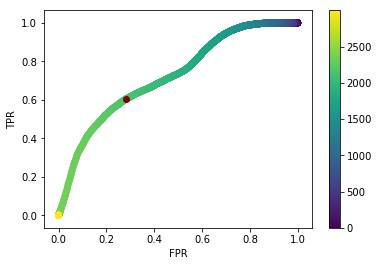

In [242]:
#Y_pred = -Y_pred
thr_min = -2
thr_max = 1
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))